In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import pairwise_distances
import time

In [11]:
(X_, y_), (_, _) = mnist.load_data()
X_ = X_.reshape(-1, 28 * 28) / 255.0
print(X_.shape)
print(y_.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784)
(60000,)


In [12]:
def get_X_y(num_datapoints = 100):
  # Get required number of datapoints.
  return X_[:num_datapoints], y_[:num_datapoints]


In [13]:
def get_X_y_index(num_datapoints = 100, start_index = 0):
  # Get required number of datapoints.
  start_point = start_index * num_datapoints
  end_point = start_point + num_datapoints
  return X_[start_point:end_point], y_[start_point:end_point]


In [14]:
def distances(X):
    # Compute squared Euclidean distances using a built-in function.
    return pairwise_distances(X, metric='euclidean', squared=True)

In [15]:
def pji(distances, beta, index):
    # Compute the P matrix.
    scaled_distances = -distances / beta
    scaled_distances -= np.max(scaled_distances)  # Shift for numerical stability
    exp_D = np.exp(scaled_distances)
    exp_D[index] = 0  # Set the diagonal elements to zero to avoid self-interaction

    return exp_D / np.sum(exp_D)


In [16]:
def perplexity(P):
    # Compute the perplexity for the given P.
    shannon_entropy = -np.sum(P * np.log2(P + 1e-10))
    return 2 ** shannon_entropy

In [17]:
def get_P(D, target_perp = 30, lower_bound = 0, upper_bound = 1e4, tol = 1e-6, maxit = 250):
    # Get the P matrix which satisfies the target perplexity threshold using binary search.
    n = D.shape[0]
    P = np.zeros(D.shape)

    # Binary search
    for i in range(n):
        LB_i = lower_bound
        UB_i = upper_bound
        d = D[i, :]

        for t in range(maxit):
            midpoint = (LB_i + UB_i)/2
            beta = 2*midpoint**2
            p_ji = pji(d, beta, i)
            current_perp = perplexity(p_ji)

            if current_perp < target_perp:
                LB_i = midpoint
            else:
                UB_i = midpoint

            if np.abs(current_perp-target_perp) < tol:
                break

        P[i,:] = p_ji

    return (P+P.T)/(2*n)

In [18]:
def get_Q(D, df=1):
    # Get the Q matrix.
    Q = np.power(1 + D/df, -1)
    np.fill_diagonal(Q, 0)

    return Q/np.sum(Q)

In [19]:
def gradient(R, Y, D, df=1):
    # Compute the gradient.
    n = Y.shape[0]
    d = Y.shape[1]
    dY = np.zeros(shape = Y.shape)

    Q = np.power(1 + D/df, -1)

    for i in range(n):
        for j in range(n):
            for k in range(d):
                dY[i,k] += 4*R[i,j]*(Y[i, k] - Y[j, k])*Q[i, j]

    return dY

In [20]:
def tsne_base(X, niter = 1000, eta = 100, d = 2, perplexity = 30):

    start_time = time.time()

    D = distances(X)
    P = 4.0 * get_P(D, perplexity) # Exaggeration

    size = (P.shape[0], d)
    Y_list = np.zeros(shape = (niter, size[0], d))

    Y = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y_list[0, :, :] = Y

    for i in range(0, niter):

        print(f"Iteration {i+1}/{niter}")

        # Stop the exaggeration after 50 steps.
        if i == 50:
            P /= 4

        # Compute gradient.
        D_ = distances(Y)
        Q = get_Q(D_)
        R = P - Q
        grad = gradient(R, Y, D_)

        # Update embeddings.
        Y_new = Y - eta*grad
        Y_list[i, :, :] = Y_new

        Y = Y_new

    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken: {end_time - start_time}")

    return Y_list, time_taken

In [21]:
def tsne_momentum(X, niter = 1000, eta = 100, d = 2, perplexity = 30,
                  alpha_init = 0.5, alpha_final = 0.8):

    start_time = time.time()

    D = distances(X)
    P = 4.0 * get_P(D, perplexity) # Exaggertion

    size = (P.shape[0], d)
    Y_list = np.zeros(shape = (niter + 2, size[0], d))

    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y1 = initial_vals
    Y2 = initial_vals

    Y_list[0, :, :] = Y1
    Y_list[1, :, :] = Y2

    alpha = alpha_init

    for i in range(2, niter + 2):

        print(f"Iteration {i-1}/{niter}")

        if i == 250:
            alpha = alpha_final # Change the momentum.

        if i == 50:
          P /= 4  # Stop the exaggeration.

        # Compute gradient.
        D_ = distances(Y1)
        Q = get_Q(D_)
        R = P - Q
        grad = gradient(R, Y1, D_)

        # Update embeddings.
        Y_new = Y1 - eta*grad + alpha*(Y1 - Y2)
        Y_list[i, :, :] = Y_new

        Y2 = Y1
        Y1 = Y_new

    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken: {end_time - start_time}")

    return Y_list, time_taken

In [22]:
from sklearn.decomposition import PCA

def pca(X, k = 30):

    # Center/scale the data.
    s = np.std(X, axis=0)
    s = np.where(s==0, 1, s)
    X = (X - np.mean(X, axis=0))/s

    # Run PCA with sklearn.
    pca_ = PCA(n_components=k)
    return pca_.fit_transform(X)

def tsne_pca(X, niter = 1000, eta = 100, d = 2, perplexity = 30,
                  alpha_init = 0.5, alpha_final = 0.8, alpha_thr = 250):

    start_time = time.time()

    X = pca(X)

    D = distances(X)
    P = 4.0 * get_P(D, perplexity) # Exaggeration

    size = (P.shape[0], d)
    Y_list = np.zeros(shape = (niter + 2, size[0], d))

    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y1 = initial_vals
    Y2 = initial_vals

    Y_list[0, :, :] = Y1
    Y_list[1, :, :] = Y2

    alpha = alpha_init

    for i in range(2, niter + 2):

        print(f"Iteration {i-1}/{niter}")

        if i == int(alpha_thr):
            alpha = alpha_final

        if i == 50:
          P /= 4  # Stop the exaggeration.

        # Compute gradient.
        D_ = distances(Y1)
        Q = get_Q(D_)
        R = P - Q
        grad = gradient(R, Y1, D_)

        # Update embeddings.
        Y_new = Y1 - eta*grad + alpha*(Y1 - Y2)
        Y_list[i, :, :] = Y_new

        Y2 = Y1
        Y1 = Y_new

    end_time = time.time()
    time_taken = end_time - start_time
    print(f"Time taken: {end_time - start_time}")

    return Y_list, time_taken

In [23]:
def visualize_embedding(Y, labels):

    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('Spectral', len(unique_labels))

    scatter = plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap=colors, s=1)

    plt.colorbar(scatter, ticks=unique_labels)
    plt.title('t-SNE embedding of the MNIST dataset')
    plt.show()

In [24]:
X, y = get_X_y(num_datapoints=1000)
print(X.shape)
print(y.shape)

(1000, 784)
(1000,)


Iteration 1/1000
Iteration 2/1000
Iteration 3/1000
Iteration 4/1000
Iteration 5/1000
Iteration 6/1000
Iteration 7/1000
Iteration 8/1000
Iteration 9/1000
Iteration 10/1000
Iteration 11/1000
Iteration 12/1000
Iteration 13/1000
Iteration 14/1000
Iteration 15/1000
Iteration 16/1000
Iteration 17/1000
Iteration 18/1000
Iteration 19/1000
Iteration 20/1000
Iteration 21/1000
Iteration 22/1000
Iteration 23/1000
Iteration 24/1000
Iteration 25/1000
Iteration 26/1000
Iteration 27/1000
Iteration 28/1000
Iteration 29/1000
Iteration 30/1000
Iteration 31/1000
Iteration 32/1000
Iteration 33/1000
Iteration 34/1000
Iteration 35/1000
Iteration 36/1000
Iteration 37/1000
Iteration 38/1000
Iteration 39/1000
Iteration 40/1000
Iteration 41/1000
Iteration 42/1000
Iteration 43/1000
Iteration 44/1000
Iteration 45/1000
Iteration 46/1000
Iteration 47/1000
Iteration 48/1000
Iteration 49/1000
Iteration 50/1000
Iteration 51/1000
Iteration 52/1000
Iteration 53/1000
Iteration 54/1000
Iteration 55/1000
Iteration 56/1000
I

<ipython-input-23-c577b5e70722>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Spectral', len(unique_labels))


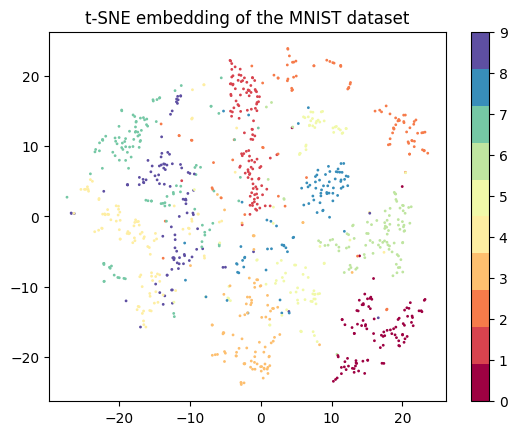

In [26]:
Y_list, _ = tsne_momentum(X, niter=1000)
visualize_embedding(Y_list[-1], y)